##### Copyright 2021 Sofiene Jerbi ([github.com/sjerbi](https://github.com/sjerbi))

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Parametrized Quantum Circuits for Reinforcement Learning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/quantum/tutorials/quantum_reinforcement_learning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/quantum/blob/master/docs/tutorials/quantum_reinforcement_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/quantum/blob/master/docs/tutorials/quantum_reinforcement_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/quantum/docs/tutorials/quantum_reinforcement_learning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial describes an implementation of two reinforcement learning (RL) algorithms based on parametrized/variational quantum circuits (PQCs or VQCs), namely policy-gradient RL and Q-learning. These algorithms were introduced in the following works, respectively:
- <a href="https://arxiv.org/abs/2103.05577" class="external">[1] Variational quantum policies for reinforcement learning</a>,
- <a href="https://arxiv.org/abs/2103.15084" class="external">[2] Quantum agents in the Gym: a variational quantum algorithm for deep Q-learning</a>.

In this tutorial, we describe how to implement a PQC with data re-uploading in TFQ, and use it as:
1. an RL policy trained with a policy-gradient method,
2. a Q-function approximator trained with deep Q-learning,

each solving [CartPole-v1](http://gym.openai.com/envs/CartPole-v1/), a benchmarking task from OpenAI Gym. Note that, as showcased in <a href="https://arxiv.org/abs/2103.05577" class="external">[1]</a> and <a href="https://arxiv.org/abs/2103.15084" class="external">[2]</a>, these implementations can also be used to solve other task-environment from OpenAI Gym, such as [FrozenLake-v0](http://gym.openai.com/envs/FrozenLake-v0/), [MountainCar-v0](http://gym.openai.com/envs/MountainCar-v0/) or [Acrobot-v1](http://gym.openai.com/envs/Acrobot-v1/).

Features of this implementation:
- it shows how to use a `tfq.layers.ControlledPQC` to implement a PQC with data re-uploading, appearing in many applications of QML. This implementation also naturally allows using trainable scaling parameters at the input of the PQC, to increase its expressivity,
- it shows how to implement observables with trainable weights at the output of a PQC, to allow a flexible range of output values,
- it shows how a `tf.keras.Model` can be trained with non-trivial ML loss functions, i.e., that are not compatible with `model.compile` and `model.fit`, using a `tf.GradientTape`.

## Setup

**<!>** To avoid automatic multiprocessing of TensorFlow, which can render the execution of this notebook slower, we recommend limiting the number of CPUs accessible to Jupyter to 1, e.g., by running the following command on Linux `taskset --cpu-list 0 jupyter notebook` when starting Jupyter.

Install TensorFlow:

In [ ]:
!pip install -q tensorflow==2.3.1

Install TensorFlow Quantum:

In [ ]:
!pip install -q tensorflow-quantum

Install Gym:

In [ ]:
!pip install gym

Now import TensorFlow and the module dependencies:

In [2]:
import tensorflow as tf
import tensorflow_quantum as tfq

import gym, cirq, sympy, random
import numpy as np
from functools import reduce
from collections import deque
from collections import namedtuple
import matplotlib.pyplot as plt

## 1. Build a PQC with data re-uploading

At the core of both RL algorithms we are implementing is a PQC that takes as input the agent's state $s$ in the environment (i.e., a numpy array) and outputs a vector of expectation values. These expectation values are then post-processed, either to produce an agent's policy $\pi(a|s)$ or approximate Q-values $Q(s,a)$. In this way, the PQCs are playing an analog role to that of deep neural networks in modern deep RL algorithms.

A popular way to encode an input vector in a PQC is through the use of single-qubit rotations, where rotation angles are controlled by the components of this input vector. In order to get a [highly-expressive model](https://arxiv.org/abs/2008.08605), these single-qubit encodings are not performed only once in the PQC, but in several "[re-uploadings](https://quantum-journal.org/papers/q-2020-02-06-226/)", interlayed with variational gates. The layout of such a PQC is depicted below:

<img src="./images/pqc_re-uploading.png" width="700">

### 1.1 Encoding layer for ControlledPQC

TFQ provides the layer class `tfq.layers.ControlledPQC`, which allows to define a PQC layer with a `numpy.darray` or `tf.Tensor` input, that can be used to specify the parameters (e.g., rotation angles) of the gates in the PQC. However, this class does not allow the input tensor to only *partially* specify these parameters, such that the unspecified parameters (i.e., variational angles) will be interpreted as variables to be trained by the resulting `tf.keras.Model`. To get around this limitation, we define a pre-processing `tf.keras.layers.Layer` in our model that "stores" all the variational parameters of our PQC and, given as input a `numpy.darray` or `tf.Tensor`, returns the appropriate input to the `tfq.layers.ControlledPQC` (i.e., all variational angles and all encoding angles for the data re-uploading).

As discussed in <a href="https://arxiv.org/abs/2103.05577" class="external">[1]</a> and <a href="https://arxiv.org/abs/2103.15084" class="external">[2]</a>, we enhance the expressivity and trainability of our data re-uploading PQCs with additional input-scaling parameters, used in each encoding gate of the PQC. These scaling parameters are also handled by the pre-processing layer that is defined below:

In [3]:
class Encoding(tf.keras.layers.Layer):
    """
    Stores all the variational parameters of the PQC, except for the observable weights,
        i.e., angles theta for variational gates and rescaling parameters lmbd for encoding gates.
    Performs the tansformation (x_1, ..., x_d) -> (theta_1, ..., theta_N, lmbd[1][1]x_1, ..., lmbd[1][M]x_1,
        ......., lmbd[d][1]x_d, ..., lmbd[d][M]x_d) for d=input_dim, N=theta_dim and M=encoding_dim
    When tanh=True, an tanh activation function is applied to all lmbd[i][j]x_i such that the resulting angles
        become bounded to [-1,1]. This tanh is useful for the Q-learning model, for instance.
    These are finally permuted such as to follow the alphabetical order of their names (provided in angles),
        as processed at the input of the ControlledPQC
    """
    def __init__(self, input_dim, theta_dim, encoding_dim, angles, tanh=False, name="encoding"):
        super(Encoding, self).__init__(name=name)
        self.input_dim = input_dim # dimension of input vector
        self.theta_dim = theta_dim # dimension of variational params vector
        self.encoding_dim = encoding_dim # number of repetitions of encoding of single input component
        theta_init = tf.random_uniform_initializer(minval=0., maxval=np.pi)
        self.theta = tf.Variable(
            initial_value=theta_init(shape=(1, theta_dim), dtype="float32"),
            trainable=True, name="thetas"
        )
        lmbd_init = tf.ones(shape=(1,input_dim*encoding_dim))
        self.lmbd = tf.Variable(
            initial_value=lmbd_init, dtype="float32",
            trainable=True, name="lambdas"
        )
        alphabetical_angles = sorted(angles)
        self.indices = tf.constant([alphabetical_angles.index(a) for a in angles]) # re-ordering of indices to
                                                                # match order of expectation_layer.symbols
        self.tanh = tanh # boolean specifying whether to apply a tanh activation on the encoding angles or not

    def call(self, inputs):
        output = tf.repeat(self.theta,repeats=tf.shape(inputs)[0],axis=0)
        repeat_inputs = tf.repeat(inputs,repeats=self.encoding_dim,axis=1)
        repeat_lmbd = tf.repeat(self.lmbd,repeats=tf.shape(inputs)[0],axis=0)
        if self.tanh:
            output = tf.concat([output, tf.keras.layers.Activation('tanh')(tf.math.multiply(repeat_inputs, repeat_lmbd))], 1)
        else:
            output = tf.concat([output, tf.math.multiply(repeat_inputs, repeat_lmbd)], 1)
        output = tf.gather(output, self.indices, axis=1) # re-ordering of indices to match order
                                                        # of expectation_layer.symbols
        return output

### 1.2 Cirq circuit for ControlledPQC

We now define the quantum circuit, implemented in Cirq, to be used by the ControlledPQC. For this, start by defining basic unitaries to be applied in the circuits, namely an arbitrary single-qubit rotation and an entangling layer of CZ gates:

In [4]:
def one_qubit_unitary(qubit, symbols):
    """
    Returns a Cirq circuit that applies a rotation of the bloch sphere about the X,
    Y and Z axis, specified by the values in `symbols`.
    """
    return cirq.Circuit(
        cirq.rx(symbols[0])(qubit),
        cirq.ry(symbols[1])(qubit),
        cirq.rz(symbols[2])(qubit))

def entangling_layer_circ(qubits):
    """
    Returns a Cirq circuit that applies a layer of entangling gates (arranged in a circular topology).
    """
    if len(qubits) == 2:
        return cirq.Circuit(cirq.CZ(qubits[0], qubits[1]))
    else:
        return cirq.Circuit(cirq.CZ(qubits[i], qubits[(i + 1) % len(qubits)]) for i in range(len(qubits)))

These are all the elements we need to define our Cirq circuit:

In [5]:
def generate_circuit(n, L, qubits):
    """
    Takes as input a number of qubits n, a number of layers L, and the qubits of the circuit.
    Returns a cirq circuit, the number of variational parameters, and the sympy symbols
    of variational and encoding angles.
    """
    # Number of variational angles
    theta_dim = 3*n*(L+1)
    
    # Sympy symbols for variational angles and encoding angles
    params = sympy.symbols('theta(0:'+str(theta_dim)+')')
    inputs = sympy.symbols('x(0:'+str(n)+')'+'(0:'+str(L)+')') # every input component encoded in one gate
                                                                # per layer
    
    # Define circuit
    circuit = cirq.Circuit()
    for l in range(L):
        # Variational layer
        for i in range(n):
            circuit += one_qubit_unitary(qubits[i], params[3*(l*n+i):3*(l*n+i+1)])
        circuit += entangling_layer_circ(qubits)
        # Encoding layer
        for i in range(n):
            circuit += cirq.rx(inputs[l+i*L])(qubits[i])
    # Last variational layer
    for i in range(n):
        circuit += one_qubit_unitary(qubits[i], params[3*(L*n+i):3*(L*n+i+1)])
    
    return circuit, theta_dim, params, inputs

## 2. Policy-gradient RL with PQC policies

In this section, we showcase the implementation of the policy-gradient algorithm presented in <a href="https://arxiv.org/abs/2103.05577" class="external">[1]</a>. We start by constructing, out of the PQC we just defined, the `softmax-VQC` policy (where VQC stands for variational quantum circuit):
$$ \pi_\theta(a|s) = \frac{e^{\beta \langle O_a \rangle_{s,\theta}}}{\sum_{a'} e^{\beta \langle O_{a'} \rangle_{s,\theta}}} $$
where $\langle O_a \rangle_{s,\theta}$ are expectation values of observables $O_a$ (one per action) measured at the output of the PQC, and $\beta$ is a tunable inverse-temperature parameter. 

We adopt the same observables used in <a href="https://arxiv.org/abs/2103.05577" class="external">[1]</a> for CartPole, namely a global $Z_0Z_1Z_2Z_3$ Pauli product acting on all qubits, weighted by an action-specific weight for each action. To implement the weighting of the Pauli product, we use an extra `tf.keras.layers.Layer` that stores the action-specific weights and applies them multiplicatively on the expectation value $\langle Z_0Z_1Z_2Z_3 \rangle_{s,\theta}$.

In [6]:
class Alternating(tf.keras.layers.Layer):
    def __init__(self, output_dim):
        super(Alternating, self).__init__()
        self.w = tf.Variable(
            initial_value=tf.constant([[(-1.)**i for i in range(output_dim)]]), dtype="float32",
            trainable=True, name="obs-weights")

    def call(self, inputs):
        return tf.matmul(inputs, self.w)

Using the `generate_circuit` function previously defined, generate the PQC:

In [7]:
n = 4 # Dimension of the state vectors in CartPole
L = 5 # Number of layers in the PQC
nb_actions = 2 # Number of actions in CartPole

qubits = [cirq.GridQubit(i,0) for i in range(n)]

circuit, theta_dim, params, inputs = generate_circuit(n, L, qubits)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


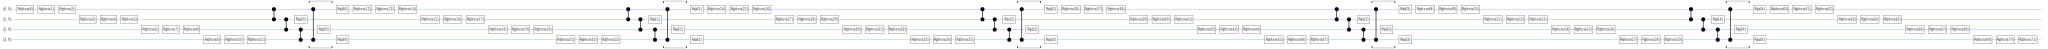

In [8]:
from cirq.contrib.svg import SVGCircuit

SVGCircuit(circuit)

and its observables:

In [9]:
ops = [cirq.Z(qubits[i]) for i in range(n)]
observables = [reduce((lambda x, y: x * y), ops)] # Z_0*Z_1*Z_2*Z_3

With this, define a `tf.keras.Model` that applies, sequentially, the `Encoding` layer previously defined, followed by a `ControlledPQC` layer using our Cirq circuit, a post-processing layer that computes the weighted observables using `Alternating`, which are then fed into a `tf.keras.layers.Softmax` layer that outputs the `softmax-VQC` policy of the agent.

In [10]:
def generate_model_policy(n, L, nb_actions, beta, circuit, theta_dim, params, inputs, observables):
    """
    Takes as input a number of qubits n, a number of layers L, a number of actions, an inverse temperature
    beta, a Cirq circuit, a number of variational angles, sympy symbols of variational and encoding angles,
    and the observables to be used at the ouput of the PQC.
    Returns the generated model of the PQC policy.
    """
    # Define input tensor
    input_tensor = tf.keras.Input(shape=(n), dtype=tf.dtypes.float32, name='input')

    # Define input quantum state
    input_q_state = tf.keras.Input(shape=(), dtype=tf.string, name='quantum_state')
    
    #Define encoding layer
    encoding_layer = Encoding(input_dim=n, theta_dim=theta_dim, encoding_dim=L, 
                          angles=[str(param) for param in params]+[str(x) for x in inputs])
    
    # Define Controlled PQC
    expectation_layer = tfq.layers.ControlledPQC(circuit, differentiator = tfq.differentiators.Adjoint(),
                                                 operators = observables, name="PQC")
    
    # Define post-processing
    expectation_values = expectation_layer([input_q_state, encoding_layer(input_tensor)])
    process = tf.keras.Sequential([
        Alternating(nb_actions),
        tf.keras.layers.Lambda(lambda x: x * beta),
        tf.keras.layers.Softmax()
    ], name="observables-policy")
    
    policy = process(expectation_values)
    
    # Define model
    model = tf.keras.Model(inputs=[input_q_state, input_tensor],
                           outputs=policy, name="policy")
    
    return model

model = generate_model_policy(n, L, nb_actions, 1., circuit, theta_dim, params, inputs, observables)

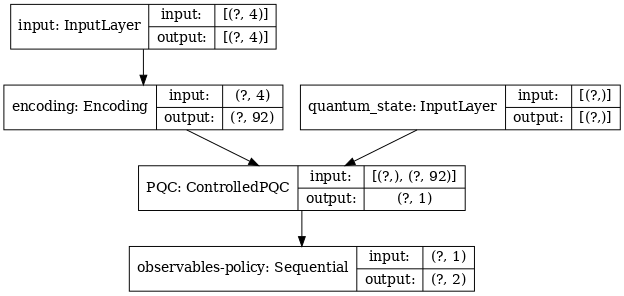

In [11]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

We can now train the PQC policy on CartPole-v1, using, e.g., the basic `REINFORCE` algorithm (see Alg. 1 in <a href="https://arxiv.org/abs/2103.05577" class="external">[1]</a>). We point out that:
1. Because scaling parameters, variational angles and observables weights are trained with different learning rates, we define 3 separate optimizers with their own learning rates, each updating one of these groups of parameters.
2. The loss function in policy-gradient RL is
    $$ \mathcal{L}(\theta) = -\frac{1}{|\mathcal{B}|}\sum_{s_0,a_0,r_1,s_1,a_1, \ldots \in \mathcal{B}} \left(\sum_{t=0}^{H-1} \log(\pi_\theta(a_t|s_t)) \sum_{t'=1}^{H-t} \gamma^{t'} r_{t+t'} \right)$$
for a batch $\mathcal{B}$ of episodes $(s_0,a_0,r_1,s_1,a_1, \ldots)$ of interactions in the environment following the policy $\pi_\theta$. This is different from a supervised learning loss with fixed target values that the model should fit, which make it impossible to use a simple function call like `model.fit` to train the policy. Instead, we use a `tf.GradientTape` to keep track of the computations involving the PQC (i.e., policy sampling) and store their contributions to the loss during the interaction. After running a batch of episodes, we can then apply backpropagation on these computations to get the gradients of the loss with respect to the PQC parameters and use our optimizers to update the policy-model.

In [11]:
env = gym.make("CartPole-v1")
state_bounds = np.array([2.4, 2.5, 0.21, 2.5])
gamma = 1
batch_size = 10
nb_epsiodes = 500
nb_batches = int(nb_epsiodes/batch_size)

# Prepare optimizers
optimizer_input = tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True)
optimizer_var = tf.keras.optimizers.Adam(learning_rate=0.01, amsgrad=True)
optimizer_output = tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True)
w_input, w_var, w_output = 1, 0, 2
if (('lambdas' not in model.trainable_variables[w_input].name)
    or ('thetas' not in model.trainable_variables[w_var].name)
    or ('obs-weights' not in model.trainable_variables[w_output].name)):
    raise ValueError("Wrong indexing of optimizers parameters.")
    
def empty_circuits(n):
    return tfq.convert_to_tensor([cirq.Circuit()]*n)

# Start training the agent
episode_reward_history = []
for batch in range(nb_batches):    
    loss_value = 0
    with tf.GradientTape() as tape:
        for episode in range(batch_size):
            action_probs_history = []
            rewards_history = []
            state = env.reset()
            episode_reward = 0
            done = False
            
            while not done:
                # Preprocess state
                state = tf.convert_to_tensor(state/state_bounds)
                state = tf.expand_dims(state, 0)

                # Compute policy from env state
                action_probs = model([empty_circuits(1),state])

                # Sample action from policy
                action = np.random.choice(nb_actions, p=action_probs[0].numpy())
                action_probs_history.append(tf.math.log(action_probs[0, action]))

                # Apply sampled action in the environment, receive reward and next state
                state, reward, done, _ = env.step(action)
                rewards_history.append(reward)
                episode_reward += reward
            
            # Compute returns 
            returns = []
            discounted_sum = 0
            for r in rewards_history[::-1]:
                discounted_sum = r + gamma * discounted_sum
                returns.insert(0, discounted_sum)
            # Normalize them for faster and more stable learning
            returns = np.array(returns)
            returns = (returns - np.mean(returns)) / (np.std(returns) + 1e-8)
            returns = returns.tolist()
            
            # Add contributions to batch loss
            history = zip(action_probs_history, returns)
            losses = []
            for log_prob, ret in history:
                losses.append(-log_prob * ret)
            loss_value += sum(losses)
            episode_reward_history.append(episode_reward)
            print("Episode {}/{}, rewards {}".format(batch*batch_size+episode+1, batch_size*nb_batches, episode_reward))
        
        # Compute gradient and train policy
        grads = tape.gradient(loss_value/batch_size, model.trainable_variables)
        optimizer_input.apply_gradients([(grads[w_input], model.trainable_variables[w_input])])
        optimizer_var.apply_gradients([(grads[w_var], model.trainable_variables[w_var])])
        optimizer_output.apply_gradients([(grads[w_output], model.trainable_variables[w_output])])

Episode 1/500, rewards 13.0
Episode 2/500, rewards 12.0
Episode 3/500, rewards 28.0
Episode 4/500, rewards 21.0
Episode 5/500, rewards 13.0
Episode 6/500, rewards 18.0
Episode 7/500, rewards 16.0
Episode 8/500, rewards 9.0
Episode 9/500, rewards 9.0
Episode 10/500, rewards 14.0
Episode 11/500, rewards 16.0
Episode 12/500, rewards 13.0
Episode 13/500, rewards 20.0
Episode 14/500, rewards 40.0
Episode 15/500, rewards 16.0
Episode 16/500, rewards 19.0
Episode 17/500, rewards 23.0
Episode 18/500, rewards 13.0
Episode 19/500, rewards 24.0
Episode 20/500, rewards 16.0
Episode 21/500, rewards 24.0
Episode 22/500, rewards 17.0
Episode 23/500, rewards 41.0
Episode 24/500, rewards 22.0
Episode 25/500, rewards 20.0
Episode 26/500, rewards 17.0
Episode 27/500, rewards 16.0
Episode 28/500, rewards 15.0
Episode 29/500, rewards 20.0
Episode 30/500, rewards 21.0
Episode 31/500, rewards 44.0
Episode 32/500, rewards 22.0
Episode 33/500, rewards 17.0
Episode 34/500, rewards 51.0
Episode 35/500, rewards 2

Episode 272/500, rewards 500.0
Episode 273/500, rewards 113.0
Episode 274/500, rewards 500.0
Episode 275/500, rewards 164.0
Episode 276/500, rewards 180.0
Episode 277/500, rewards 500.0
Episode 278/500, rewards 500.0
Episode 279/500, rewards 223.0
Episode 280/500, rewards 500.0
Episode 281/500, rewards 500.0
Episode 282/500, rewards 500.0
Episode 283/500, rewards 228.0
Episode 284/500, rewards 216.0
Episode 285/500, rewards 500.0
Episode 286/500, rewards 500.0
Episode 287/500, rewards 500.0
Episode 288/500, rewards 500.0
Episode 289/500, rewards 500.0
Episode 290/500, rewards 244.0
Episode 291/500, rewards 500.0
Episode 292/500, rewards 500.0
Episode 293/500, rewards 500.0
Episode 294/500, rewards 220.0
Episode 295/500, rewards 500.0
Episode 296/500, rewards 500.0
Episode 297/500, rewards 500.0
Episode 298/500, rewards 500.0
Episode 299/500, rewards 500.0
Episode 300/500, rewards 500.0
Episode 301/500, rewards 500.0
Episode 302/500, rewards 500.0
Episode 303/500, rewards 400.0
Episode 

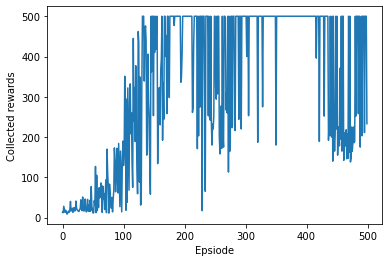

In [12]:
plt.plot(episode_reward_history)
plt.xlabel('Epsiode')
plt.ylabel('Collected rewards')
plt.show()

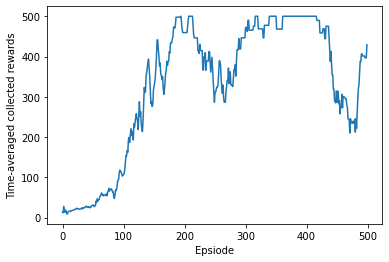

In [15]:
plt.plot(episode_reward_history[:10]+[np.mean(episode_reward_history[i-10:i]) for i in range(10,len(episode_reward_history))])
plt.xlabel('Epsiode')
plt.ylabel('Time-averaged collected rewards')
plt.show()

## 3. Deep Q-learning with PQC Q-function approximators

In this section, we move to the implementation of the deep Q-learning algorithm presented in <a href="https://arxiv.org/abs/2103.15084" class="external">[2]</a>. As opposed to a policy-gradient approach, the deep Q-learning method uses a PQC to approximate the Q-function of the agent. That is, the PQC defines a function approximator:
$$ Q_\theta(s,a) = \langle O_a \rangle_{s,\theta} $$
where $\langle O_a \rangle_{s,\theta}$ are expectation values of observables $O_a$ (one per action) measured at the ouput of the PQC.

These Q-values are updated using a loss function derived from Q-learning:
$$ \mathcal{L}(\theta) = \frac{1}{|\mathcal{B}|}\sum_{s,a,r,s' \in \mathcal{B}} \left(Q_\theta(s,a) - [r +\max_{a'} Q_{\theta'}(s',a')]\right)^2$$
for a batch $\mathcal{B}$ of $1$-step interactions $(s,a,r,s')$ with the environment, sampled from the replay memory, and parameters $\theta'$ specifying the target PQC (i.e., a copy of the main PQC, whose parameters are sporadically copied from the main PQC throughout learning).

We adopt the same observables used in <a href="https://arxiv.org/abs/2103.15084" class="external">[2]</a> for CartPole, namely a $Z_0Z_1$ Pauli product for action $0$ and a $Z_2Z_3$ Pauli product for action $1$. Both observables are re-scaled so their expectation values are in $[0,1]$ and weighted by an action-specific weight. To implement the re-scaling and weighting of the Pauli products, we define again an extra `tf.keras.layers.Layer` that stores the action-specific weights and applies them multiplicatively on the expectation values $\left(1+\langle Z_0Z_1 \rangle_{s,\theta}\right)/2$ and $\left(1+\langle Z_2Z_3 \rangle_{s,\theta}\right)/2$.

In [12]:
class Rescaling(tf.keras.layers.Layer):
    def __init__(self, input_dim):
        super(Rescaling, self).__init__()
        self.input_dim = input_dim
        self.w = tf.Variable(
            initial_value=tf.ones(shape=(1,input_dim)), dtype="float32",
            trainable=True, name="obs-weights")

    def call(self, inputs):
        return tf.math.multiply((inputs+1)/2, tf.repeat(self.w,repeats=tf.shape(inputs)[0],axis=0))

Using the `generate_circuit` function, generate the PQC and its observables:

In [13]:
n = 4 # Dimension of the state vectors in CartPole
L = 5 # Number of layers in the PQC
nb_actions = 2 # Number of actions in CartPole
qubits = [cirq.GridQubit(i,0) for i in range(n)]
circuit, theta_dim, params, inputs = generate_circuit(n, L, qubits)
ops = [cirq.Z(qubits[i]) for i in range(n)]
observables = [ops[0]*ops[1], ops[2]*ops[3]] # Z_0*Z_1 for action 0 and Z_2*Z_3 for action 1

Define a `tf.keras.Model` that, similarly to the PQC-policy model, constructs a Q-function approximator that is used to generate the main and target models of our Q-learning agent.

In [14]:
def generate_model_Qlearning(n, L, circuit, theta_dim, params, inputs, observables, target):
    """
    Takes as input a number of qubits n, a number of layers L, a Cirq circuit, a number of variational angles,
    sympy symbols of variational and encoding angles, the observables to be used at the ouput of the PQC,
    and a boolean specifying if the generated model is a target model or main model.
    Returns the generated model of the PQC Q-function approximator.
    """
    # Define input tensor
    input_tensor = tf.keras.Input(shape=(n), dtype=tf.dtypes.float32, name='input')

    # Define input quantum state
    input_q_state = tf.keras.Input(shape=(), dtype=tf.string, name='quantum_state')
    
    #Define encoding layer
    encoding_layer = Encoding(input_dim=n, theta_dim=theta_dim, encoding_dim=L, 
                          angles=[str(param) for param in params]+[str(x) for x in inputs], tanh=True)
    
    # Define Controlled PQC
    expectation_layer = tfq.layers.ControlledPQC(circuit, differentiator = tfq.differentiators.Adjoint(),
                                                 operators = observables, name="PQC")
    
    prepend = ""
    if target:
        prepend = "Target"
    
    # Define post-processing
    expectation_values = expectation_layer([input_q_state, encoding_layer(input_tensor)])
    process = tf.keras.Sequential([
        Rescaling(len(observables))
    ], name=prepend+"Q-values")
    
    Q_values = process(expectation_values)
    
    # Define model
    model = tf.keras.Model(inputs=[input_q_state, input_tensor],
                           outputs=Q_values, name=prepend+"Q-function")
    
    return model

model = generate_model_Qlearning(n, L, circuit, theta_dim, params, inputs, observables, False)
model_target = generate_model_Qlearning(n, L, circuit, theta_dim, params, inputs, observables, True)

model_target.set_weights(model.get_weights())

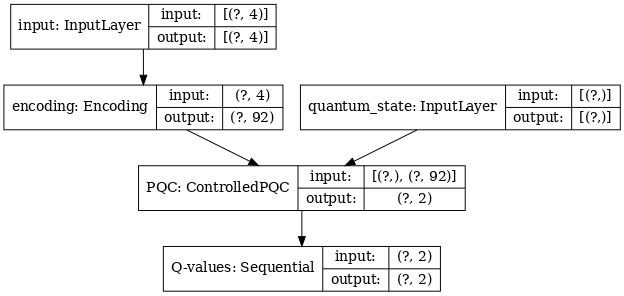

In [15]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

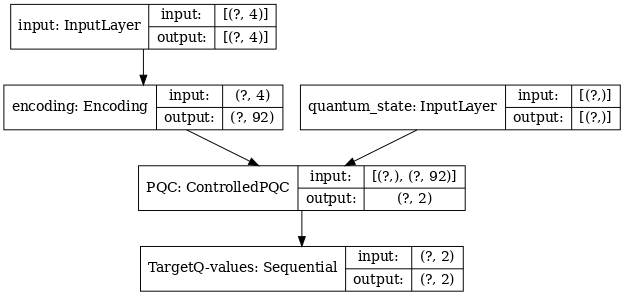

In [16]:
tf.keras.utils.plot_model(model_target, show_shapes=True, dpi=70)

We now implement the deep Q-learning algorithm and test it on the CartPole-v1 environment. We use an $\varepsilon$-greedy policy:
$$ \pi(a|s) =
\begin{cases}
\delta_{a,\text{argmax}_{a'} Q_\theta(s,a')}\quad \text{w.p.}\quad 1 - \varepsilon\\
\frac{1}{\text{num_actions}}\quad \quad \quad \quad \text{w.p.}\quad \varepsilon
\end{cases} $$
where $\varepsilon$ is multiplicatively decayed at each episode of interaction.

**<!> CAREFUL <!>** The following cell can take several hours to run, depending on the performance of the agent. Its execution can however be interrupted at any point while still resulting in a trained PQC model that can be studied.

In [17]:
env = gym.make("CartPole-v1")
# state_bounds = np.array([2.4, 2.5, 0.21, 2.5])
state_bounds = np.array([1.,1.,1.,1.])
gamma = 0.99
nb_episodes = 2500

interaction = namedtuple('interaction', ('state', 'action', 'reward', 'next_state', 'done'))

# Define replay memory
max_memory_length = 10000 # Maximum replay length
replay_memory = deque(maxlen=max_memory_length)

epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.01  # Minimum epsilon greedy parameter
decay_epsilon = 0.99 # Decay rate of epsilon greedy parameter
batch_size = 16
# Train the model every update_VQC steps
update_VQC = 10
# Update the target model every update_target steps
update_target = 30

# Prepare loss function
loss_function = tf.keras.losses.Huber()

# Prepare optimizers
optimizer_input = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
optimizer_var = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
optimizer_output = tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True)
w_input, w_var, w_output = 1, 0, 2
if (('lambdas' not in model.trainable_variables[w_input].name)
    or ('thetas' not in model.trainable_variables[w_var].name)
    or ('obs-weights' not in model.trainable_variables[w_output].name)):
    raise ValueError("Wrong indexing of optimizers parameters.")
    
episode_reward_history = []

step_count = 0
for episode in range(nb_episodes):
    episode_reward = 0
    state = env.reset()
    done = False
    
    while not done:
        # Increase step count
        step_count += 1
        
        # Preprocess state
        state_array = np.array(state) 
        state = tf.convert_to_tensor(state_array/state_bounds)
        state = tf.expand_dims(state, 0)

        # Sample action
        coin = random.random()
        if coin > epsilon:
            q_vals = model([empty_circuits(1),state])
            action = int(tf.argmax(q_vals[0]).numpy())
        else:
            action = np.random.choice(nb_actions)
        
        # Apply sampled action in the environment, receive reward and next state
        next_state, reward, done, _ = env.step(action)
        
        # Store last interaction in the replay memory
        sarsd = interaction(np.copy(state_array), action, reward, np.copy(next_state), float(done))
        replay_memory.append(sarsd)
        
        state = np.array(next_state)
        episode_reward += reward
        
        # Update model
        if step_count % update_VQC == 0 and len(replay_memory) >= batch_size:
            # Sample a batch of interactions
            batch = random.choices(replay_memory, k=batch_size)
            batch = interaction(*zip(*batch))
            
            # Compute their target q_values and the masks on sampled actions
            future_rewards = model_target.predict([empty_circuits(batch_size),tf.constant(batch.next_state)])
            target_q_values = tf.constant(batch.reward) + (gamma * tf.reduce_max(future_rewards, axis=1)
                                                           * (1 - tf.constant(batch.done)))
            masks = tf.one_hot(batch.action, nb_actions)

            # Train the model on the states and target Q-values
            with tf.GradientTape() as tape:
                q_values = model([empty_circuits(batch_size),tf.constant(batch.state)])
                # Apply the masks to the Q-values
                q_values_masked = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between target Q-values and model Q-values
                loss = loss_function(target_q_values, q_values_masked)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer_input.apply_gradients([(grads[w_input], model.trainable_variables[w_input])])
            optimizer_var.apply_gradients([(grads[w_var], model.trainable_variables[w_var])])
            optimizer_output.apply_gradients([(grads[w_output], model.trainable_variables[w_output])])
        
        # Update target model
        if episode % update_target == 0:
            model_target.set_weights(model.get_weights())

    # Decay epsilon
    epsilon = max(epsilon * decay_epsilon, epsilon_min)
    episode_reward_history.append(episode_reward)
    print("Episode {}/{}, rewards {}".format(episode+1, nb_episodes, episode_reward))

Episode 1/2500, rewards 17.0
Episode 2/2500, rewards 10.0
Episode 3/2500, rewards 16.0
Episode 4/2500, rewards 17.0
Episode 5/2500, rewards 39.0
Episode 6/2500, rewards 19.0
Episode 7/2500, rewards 18.0
Episode 8/2500, rewards 8.0
Episode 9/2500, rewards 24.0
Episode 10/2500, rewards 14.0
Episode 11/2500, rewards 13.0
Episode 12/2500, rewards 17.0
Episode 13/2500, rewards 15.0
Episode 14/2500, rewards 11.0
Episode 15/2500, rewards 19.0
Episode 16/2500, rewards 17.0
Episode 17/2500, rewards 17.0
Episode 18/2500, rewards 9.0
Episode 19/2500, rewards 18.0
Episode 20/2500, rewards 14.0
Episode 21/2500, rewards 21.0
Episode 22/2500, rewards 20.0
Episode 23/2500, rewards 34.0
Episode 24/2500, rewards 16.0
Episode 25/2500, rewards 16.0
Episode 26/2500, rewards 15.0
Episode 27/2500, rewards 20.0
Episode 28/2500, rewards 18.0
Episode 29/2500, rewards 37.0
Episode 30/2500, rewards 23.0
Episode 31/2500, rewards 16.0
Episode 32/2500, rewards 30.0
Episode 33/2500, rewards 53.0
Episode 34/2500, rewa

Episode 325/2500, rewards 31.0
Episode 326/2500, rewards 50.0
Episode 327/2500, rewards 34.0
Episode 328/2500, rewards 42.0
Episode 329/2500, rewards 44.0
Episode 330/2500, rewards 30.0
Episode 331/2500, rewards 33.0
Episode 332/2500, rewards 33.0
Episode 333/2500, rewards 43.0
Episode 334/2500, rewards 88.0
Episode 335/2500, rewards 30.0
Episode 336/2500, rewards 31.0
Episode 337/2500, rewards 27.0
Episode 338/2500, rewards 65.0
Episode 339/2500, rewards 51.0
Episode 340/2500, rewards 85.0
Episode 341/2500, rewards 64.0
Episode 342/2500, rewards 90.0
Episode 343/2500, rewards 72.0
Episode 344/2500, rewards 41.0
Episode 345/2500, rewards 34.0
Episode 346/2500, rewards 204.0
Episode 347/2500, rewards 30.0
Episode 348/2500, rewards 36.0
Episode 349/2500, rewards 43.0
Episode 350/2500, rewards 90.0
Episode 351/2500, rewards 49.0
Episode 352/2500, rewards 61.0
Episode 353/2500, rewards 88.0
Episode 354/2500, rewards 86.0
Episode 355/2500, rewards 114.0
Episode 356/2500, rewards 55.0
Episod

Episode 648/2500, rewards 200.0
Episode 649/2500, rewards 142.0
Episode 650/2500, rewards 132.0
Episode 651/2500, rewards 270.0
Episode 652/2500, rewards 185.0
Episode 653/2500, rewards 196.0
Episode 654/2500, rewards 174.0
Episode 655/2500, rewards 136.0
Episode 656/2500, rewards 148.0
Episode 657/2500, rewards 169.0
Episode 658/2500, rewards 174.0
Episode 659/2500, rewards 216.0
Episode 660/2500, rewards 185.0
Episode 661/2500, rewards 167.0
Episode 662/2500, rewards 176.0
Episode 663/2500, rewards 422.0
Episode 664/2500, rewards 177.0
Episode 665/2500, rewards 148.0
Episode 666/2500, rewards 131.0
Episode 667/2500, rewards 118.0
Episode 668/2500, rewards 152.0
Episode 669/2500, rewards 120.0
Episode 670/2500, rewards 179.0
Episode 671/2500, rewards 148.0
Episode 672/2500, rewards 117.0
Episode 673/2500, rewards 117.0
Episode 674/2500, rewards 134.0
Episode 675/2500, rewards 142.0
Episode 676/2500, rewards 122.0
Episode 677/2500, rewards 146.0
Episode 678/2500, rewards 144.0
Episode 

Episode 975/2500, rewards 196.0
Episode 976/2500, rewards 208.0
Episode 977/2500, rewards 453.0
Episode 978/2500, rewards 235.0
Episode 979/2500, rewards 330.0
Episode 980/2500, rewards 288.0
Episode 981/2500, rewards 252.0
Episode 982/2500, rewards 169.0
Episode 983/2500, rewards 182.0
Episode 984/2500, rewards 183.0
Episode 985/2500, rewards 194.0
Episode 986/2500, rewards 159.0
Episode 987/2500, rewards 168.0
Episode 988/2500, rewards 185.0
Episode 989/2500, rewards 158.0
Episode 990/2500, rewards 146.0
Episode 991/2500, rewards 168.0
Episode 992/2500, rewards 188.0
Episode 993/2500, rewards 184.0
Episode 994/2500, rewards 225.0
Episode 995/2500, rewards 217.0
Episode 996/2500, rewards 217.0
Episode 997/2500, rewards 197.0
Episode 998/2500, rewards 157.0
Episode 999/2500, rewards 240.0
Episode 1000/2500, rewards 264.0
Episode 1001/2500, rewards 270.0
Episode 1002/2500, rewards 214.0
Episode 1003/2500, rewards 242.0
Episode 1004/2500, rewards 250.0
Episode 1005/2500, rewards 257.0
Ep

Episode 1297/2500, rewards 248.0
Episode 1298/2500, rewards 266.0
Episode 1299/2500, rewards 200.0
Episode 1300/2500, rewards 374.0
Episode 1301/2500, rewards 252.0
Episode 1302/2500, rewards 342.0
Episode 1303/2500, rewards 284.0
Episode 1304/2500, rewards 337.0
Episode 1305/2500, rewards 451.0
Episode 1306/2500, rewards 259.0
Episode 1307/2500, rewards 265.0
Episode 1308/2500, rewards 240.0
Episode 1309/2500, rewards 340.0
Episode 1310/2500, rewards 413.0
Episode 1311/2500, rewards 280.0
Episode 1312/2500, rewards 234.0
Episode 1313/2500, rewards 500.0
Episode 1314/2500, rewards 290.0
Episode 1315/2500, rewards 249.0
Episode 1316/2500, rewards 364.0
Episode 1317/2500, rewards 282.0
Episode 1318/2500, rewards 479.0
Episode 1319/2500, rewards 500.0
Episode 1320/2500, rewards 238.0
Episode 1321/2500, rewards 500.0
Episode 1322/2500, rewards 239.0
Episode 1323/2500, rewards 257.0
Episode 1324/2500, rewards 325.0
Episode 1325/2500, rewards 344.0
Episode 1326/2500, rewards 500.0
Episode 13

Episode 1609/2500, rewards 411.0
Episode 1610/2500, rewards 500.0
Episode 1611/2500, rewards 500.0
Episode 1612/2500, rewards 363.0
Episode 1613/2500, rewards 349.0
Episode 1614/2500, rewards 378.0
Episode 1615/2500, rewards 391.0
Episode 1616/2500, rewards 500.0
Episode 1617/2500, rewards 369.0
Episode 1618/2500, rewards 406.0
Episode 1619/2500, rewards 349.0
Episode 1620/2500, rewards 323.0
Episode 1621/2500, rewards 369.0
Episode 1622/2500, rewards 498.0
Episode 1623/2500, rewards 396.0
Episode 1624/2500, rewards 406.0
Episode 1625/2500, rewards 433.0
Episode 1626/2500, rewards 347.0
Episode 1627/2500, rewards 349.0
Episode 1628/2500, rewards 336.0
Episode 1629/2500, rewards 346.0
Episode 1630/2500, rewards 431.0
Episode 1631/2500, rewards 439.0
Episode 1632/2500, rewards 366.0
Episode 1633/2500, rewards 500.0
Episode 1634/2500, rewards 455.0
Episode 1635/2500, rewards 428.0
Episode 1636/2500, rewards 500.0
Episode 1637/2500, rewards 374.0
Episode 1638/2500, rewards 500.0
Episode 16

Episode 1915/2500, rewards 500.0
Episode 1916/2500, rewards 500.0
Episode 1917/2500, rewards 500.0
Episode 1918/2500, rewards 500.0
Episode 1919/2500, rewards 500.0
Episode 1920/2500, rewards 500.0
Episode 1921/2500, rewards 500.0
Episode 1922/2500, rewards 500.0
Episode 1923/2500, rewards 500.0
Episode 1924/2500, rewards 500.0
Episode 1925/2500, rewards 500.0
Episode 1926/2500, rewards 500.0
Episode 1927/2500, rewards 500.0
Episode 1928/2500, rewards 500.0
Episode 1929/2500, rewards 500.0
Episode 1930/2500, rewards 500.0
Episode 1931/2500, rewards 500.0
Episode 1932/2500, rewards 500.0
Episode 1933/2500, rewards 500.0
Episode 1934/2500, rewards 500.0
Episode 1935/2500, rewards 500.0
Episode 1936/2500, rewards 500.0
Episode 1937/2500, rewards 500.0
Episode 1938/2500, rewards 500.0
Episode 1939/2500, rewards 500.0
Episode 1940/2500, rewards 500.0
Episode 1941/2500, rewards 500.0
Episode 1942/2500, rewards 500.0
Episode 1943/2500, rewards 500.0
Episode 1944/2500, rewards 500.0
Episode 19

Episode 2224/2500, rewards 500.0
Episode 2225/2500, rewards 500.0
Episode 2226/2500, rewards 500.0
Episode 2227/2500, rewards 500.0
Episode 2228/2500, rewards 500.0
Episode 2229/2500, rewards 500.0
Episode 2230/2500, rewards 500.0
Episode 2231/2500, rewards 500.0
Episode 2232/2500, rewards 500.0
Episode 2233/2500, rewards 500.0
Episode 2234/2500, rewards 500.0
Episode 2235/2500, rewards 500.0
Episode 2236/2500, rewards 500.0
Episode 2237/2500, rewards 500.0
Episode 2238/2500, rewards 500.0
Episode 2239/2500, rewards 500.0
Episode 2240/2500, rewards 500.0
Episode 2241/2500, rewards 500.0
Episode 2242/2500, rewards 500.0
Episode 2243/2500, rewards 500.0
Episode 2244/2500, rewards 500.0
Episode 2245/2500, rewards 500.0
Episode 2246/2500, rewards 500.0
Episode 2247/2500, rewards 500.0
Episode 2248/2500, rewards 500.0
Episode 2249/2500, rewards 500.0
Episode 2250/2500, rewards 500.0
Episode 2251/2500, rewards 500.0
Episode 2252/2500, rewards 500.0
Episode 2253/2500, rewards 500.0
Episode 22

KeyboardInterrupt: 

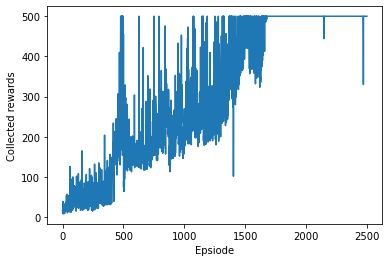

In [18]:
plt.plot(episode_reward_history)
plt.xlabel('Epsiode')
plt.ylabel('Collected rewards')
plt.show()

## 4. Exercise

Combine the PQC models of the last two sections into an [actor-critic agent](https://lilianweng.github.io/lil-log/2018/04/08/policy-gradient-algorithms.html#actor-critic) that solves CartPole.